# Implementing Expectation Maximization Algorithm For Clustering Image Dataset

### This implementation is based on Machine Learning: Clustering and Retrival Course by University of Washington on Coursera

This complete implementation is divided into two parts. In Part I, the algorithm is implemented on a set synthetic data (mixture of Gaussian random variables). Once it is established that the algorithm is working as expected it is applied on a set of images for clustering. This is done in Part II. 

## Part I

In [228]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy                                                    # deep copies

# image handling library
from PIL import Image
from io import BytesIO

In [ ]:
# Generating synthetic data
def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        k = np.random.choice(len(weights), 1, p=weights)[0]
        x = np.random.multivariate_normal(means[k], covariances[k])
        data.append(x)
    return data


init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

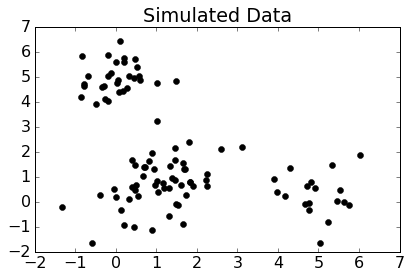

In [233]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()
plt.title('Simulated Data')
plt.show()

In [63]:
def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0
    for d in data:
        
        Z = np.zeros(num_clusters)
        for k in range(num_clusters):
            
            # Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delta = np.array(d) - means[k]
            exponent_term = np.dot(delta.T, np.dot(np.linalg.inv(covs[k]), delta))
            
            # Compute loglikelihood contribution for this data point and this cluster
            Z[k] += np.log(weights[k])
            Z[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        # Increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(Z)
        
    return ll

In [ ]:
# Initialization of parameters

np.random.seed(100)

chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] 
initial_weights = [1/3.] * 3 

means = init_means[:]
covariances = init_covariances[:]
weights = init_weights[:]

num_data = len(data)
num_dim = len(data[0])
num_clusters = len(means)

resp = np.zeros((num_data, num_clusters))
ll = loglikelihood(data, weights, means, covariances)
ll_trace = [ll]

maxIter=1000
thresh=1e-4

# Optimization loops

for it in range(maxIter):
    if it % 5 == 0:
        print("Iteration %s" % it)
    resp = np.zeros((num_data, num_clusters))
    for i in range(num_data):
        for k in range(num_clusters):
            resp[i, k] =  weights[k]*multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])
    
    row_sums = resp.sum(axis=1)[:, np.newaxis]
    resp = resp / row_sums
    
    counts = np.sum(resp, axis=0)
    
    weights = [0.] * num_clusters
    
    for k in range(num_clusters):
        N=np.sum(counts,axis=0)
        weights[k] = counts[k]/N
    
    means = [np.zeros(len(data[0]))] * num_clusters
        
    for k in range(num_clusters):
        weighted_sum = 0.
        for i in range(num_data):
            weighted_sum += resp[i,k]*data[i]
        means[k] = weighted_sum/counts[k]
    
    covariances = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            weighted_sum +=  resp[i,k]*(np.outer(data[i]-means[k],data[i]-means[k]))
        covariances[k] = weighted_sum/counts[k]
    
    ll_latest = loglikelihood(data, weights, means, covariances)
    ll_trace.append(ll_latest)
        
    if (ll_latest - ll) < thresh and ll_latest > -np.inf:
        break
    ll = ll_latest
    
if it % 5 != 0:
    print("Iteration %s" % it)
    
out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

In [229]:
import matplotlib.mlab as mlab
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()
    plt.show()

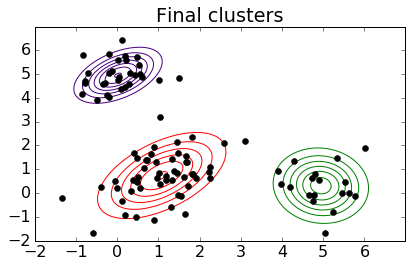

In [230]:
plot_contours(data, out['means'], out['covs'], 'Final clusters')